In this notebook, we will experiment with ML for market price prediction using three regression methods: 

*   Simple Linear Regression
*   Polynomial Regression
*   Random Forest Regression

We are analyzing charts of Bitcoin's price against the US dollar, taken from Yahoo's own financial data. 




In [14]:
# import necessary packages
import numpy as np
import pandas as pd

#import datetime ##yahoo finance deprecated, 'live' data extraction causing infinite issues

#import pandas_datareader.data as web
#from pandas import Series, DataFrame

#currentDT = datetime.datetime.now()

## range : beginning of this dataset to current date
#start = datetime.datetime(2010, 7, 17) # change this if using different dataset #2010
#end = datetime.datetime(currentDT.year, currentDT.month, currentDT.day)

#df = web.DataReader("BTC-USD", 'yahoo', start, end) # using bitcoin data by default

#imports for style and visualization
# import the seaborn module
import seaborn as sns
# import the matplotlib module
import matplotlib.pyplot as plt
# set the background colour of the plot to white
sns.set(style="whitegrid", color_codes=True)
# setting the plot size for all plots
sns.set(rc={'figure.figsize':(11.7,8.27)})
# Remove the top and down margin
sns.despine(offset=10, trim=True)
# display the plotplt.show()

import matplotlib as mpl
import matplotlib.pyplot as plt


from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD

Using TensorFlow backend.


<Figure size 842.4x595.44 with 0 Axes>

In [15]:
# Download the data and store it
# Bitcoin price since the beginning
!wget -O BTC-USD.csv https://www.dropbox.com/s/d4dnlgx4c5n6xta/BTC-USD.csv?dl=0

--2019-09-08 12:46:13--  https://www.dropbox.com/s/d4dnlgx4c5n6xta/BTC-USD.csv?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.1, 2620:100:6016:1::a27d:101
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/d4dnlgx4c5n6xta/BTC-USD.csv [following]
--2019-09-08 12:46:13--  https://www.dropbox.com/s/raw/d4dnlgx4c5n6xta/BTC-USD.csv
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc39c1e19d92954bf33847af5983.dl.dropboxusercontent.com/cd/0/inline/AoITgb0ItovBRK0Lu8bqLAtIcoKmHw3S81D7S20T-2NvfapwzfPd8CIt_j4Vi_xkpQTj_nEhTq3Wm2hJTAhpQ7jJtxFQB3up-iUFz9dPLVceVaJuFbCZ-1EOUMvmP3Sp2Mo/file# [following]
--2019-09-08 12:46:13--  https://uc39c1e19d92954bf33847af5983.dl.dropboxusercontent.com/cd/0/inline/AoITgb0ItovBRK0Lu8bqLAtIcoKmHw3S81D7S20T-2NvfapwzfPd8CIt_j4Vi_xkpQTj_nEhTq3Wm2hJTAhpQ7jJtxFQB3up-iUFz9dPLVceVaJu

We'll test out a line graph of the closing price for each date across the entire dataset.

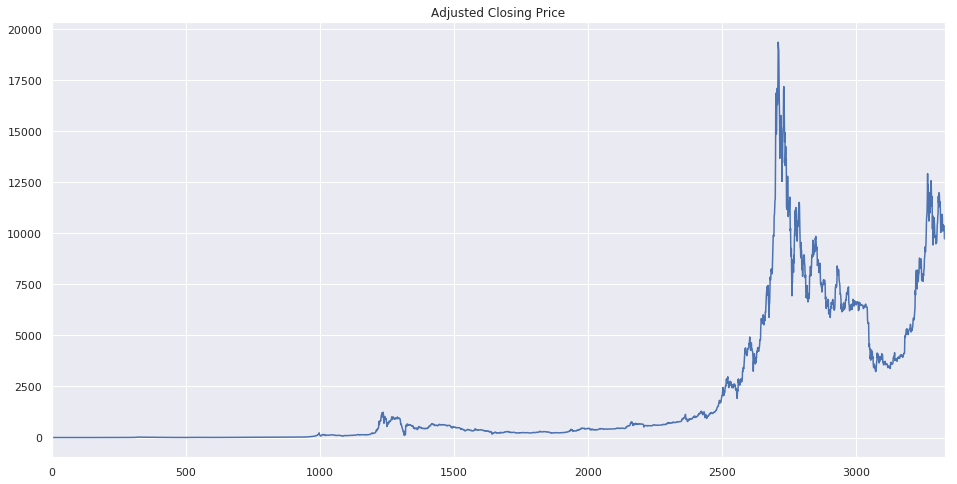

In [18]:
df = pd.read_csv('BTC-USD.csv')
df['Adj Close'].plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

To make this more robust to noise and to leverage past values, we will not use the date to predict the stock prices, but we will use the batches of 32 prices from the past to predict the price on the 32rd day. We will thise have N-32 training examples with N being the number of days we've downloaded for the stock data. We will thus create a 2D matrix of training samples with each row being the prices of 32 consecutive days in the past with the price to predict being the current day. 

In [0]:
window_size = 32 # Allow us to look at 32 days into the past
# Prepare the data so that we have 32 day windows and predict what the next day should be

# Get indices of access for the data
num_samples = len(df) - window_size
indices = np.arange(num_samples).astype(np.int)[:,None] + np.arange(window_size + 1).astype(np.int)

In [0]:
data = df['Adj Close'].values[indices] # Create the 2D matrix of training samples

We create a 2D matrix such that we have 33 columns per example. The training samples will be the first 32 columns with the target variable being the last column.

In [0]:
X = data[:,:-1] # Each row represents 32 days in the past
y = data[:,-1] # Each output value represents the 33rd day

Perform train/test split such that the first 80% of the prices is the training set and the last 20% of the prices is the test dataset. We will train on the training set and test the performance on the test set to see how well we can forecast the price for Bitcoin.

In [0]:
# Train and test split
split_fraction = 0.8
ind_split = int(split_fraction * num_samples)
X_train = X[:ind_split]
y_train = y[:ind_split]
X_test = X[ind_split:]
y_test = y[ind_split:]

## Method #1 - Ordinary Least Squares
We will use the Ordinary Least Squares method from Scikit-learn where we'll train and perform inference on the training and test data respectively. Let's also plot how it compares with the actual data for both training and test.

https://scikit-learn.org/stable/modules/linear_model.html#ordinary-least-squares

In [0]:
# train the model
ols_model = linear_model.LinearRegression()
ols_model.fit(X_train, y_train)


# perform the inference
y_pred_train_ols = ols_model.predict(X_train)
y_pred_ols = ols_model.predict(X_test)

We can print out the mean squared error and variance to get a feel for how well the model has trained.

In [25]:
# The coefficients for the training data
print('Coefficients: \n', ols_model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_train, y_pred_train_ols))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_train, y_pred_train_ols))

Coefficients: 
 [ 0.0421127   0.04721666  0.17704588 -0.06688877 -0.2781663   0.08201327
  0.0079279  -0.07532848  0.09718263 -0.02304314  0.04817413 -0.11943025
  0.03804092 -0.013822   -0.04754407  0.09680125 -0.00330381 -0.01321802
  0.0118035  -0.05380954  0.05807782  0.00805224 -0.00796188  0.05001721
 -0.04009085 -0.02152822 -0.00764628  0.0493684  -0.06066453  0.01754989
  0.06134503  0.95018705]
Mean squared error: 2221.30
Variance score: 1.00


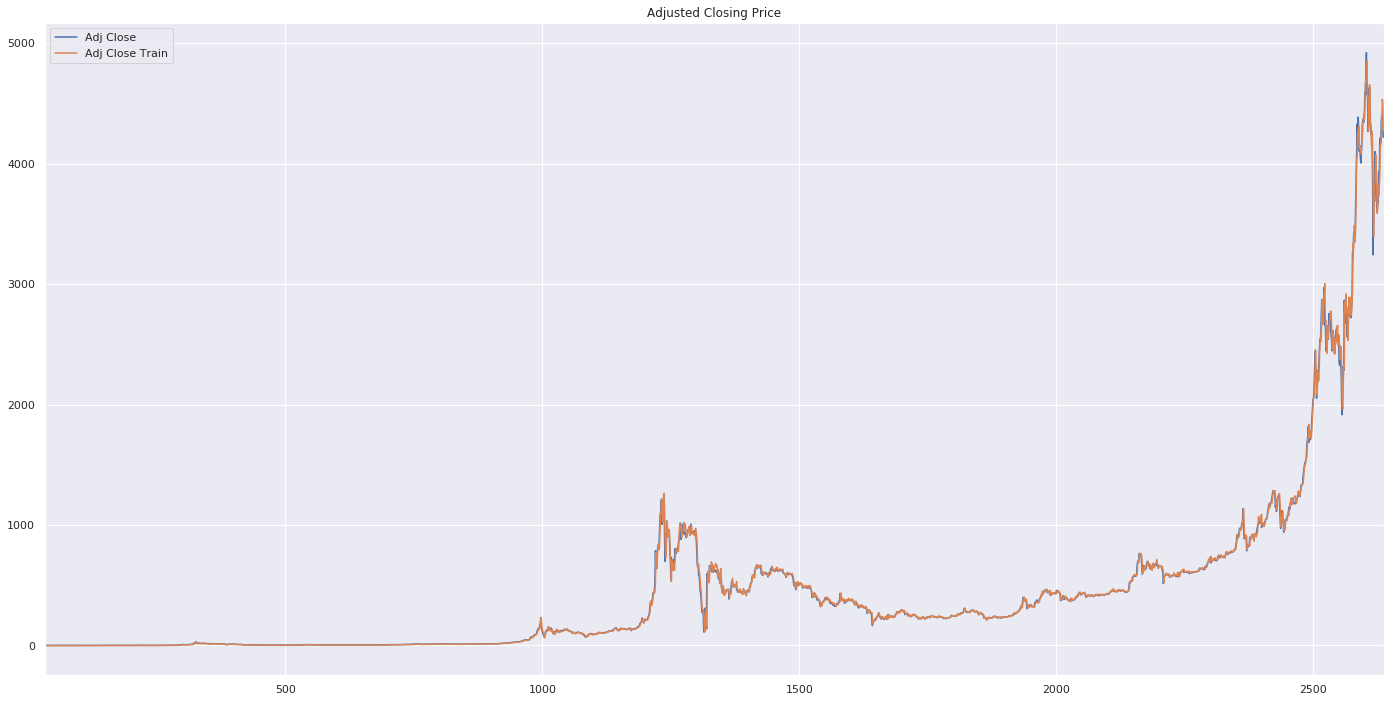

In [26]:
# Plot what it looks like for the training data
df_ols = df.copy()
df_ols.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ols = df_ols.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_ols['Adj Close Train'] = y_pred_train_ols[:-window_size]
df_ols.plot(label='BTC-USD', figsize=(24,12), title='Adjusted Closing Price', grid=True)
#plt.xlim(end - datetime.timedelta(days = window_size), end)

It's done fine on the training set. We'll check how it performs on the test set.

In [27]:
# The coefficients for the test data
print('Coefficients: \n', ols_model.coef_)
# The mean squared error
print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred_ols))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % r2_score(y_test, y_pred_ols))

Coefficients: 
 [ 0.0421127   0.04721666  0.17704588 -0.06688877 -0.2781663   0.08201327
  0.0079279  -0.07532848  0.09718263 -0.02304314  0.04817413 -0.11943025
  0.03804092 -0.013822   -0.04754407  0.09680125 -0.00330381 -0.01321802
  0.0118035  -0.05380954  0.05807782  0.00805224 -0.00796188  0.05001721
 -0.04009085 -0.02152822 -0.00764628  0.0493684  -0.06066453  0.01754989
  0.06134503  0.95018705]
Mean squared error: 236319.87
Variance score: 0.98


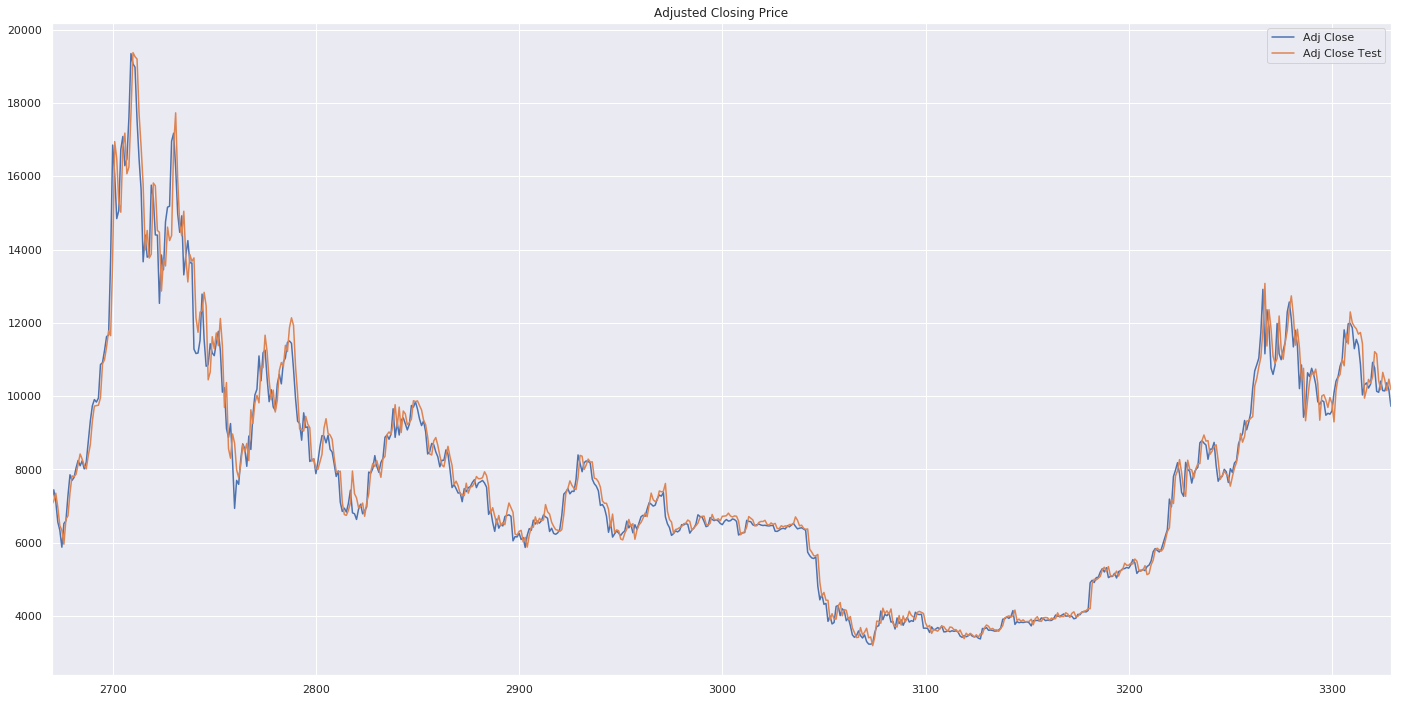

In [28]:
# Same for the test
df_ols = df.copy()
df_ols.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_ols = df_ols.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_ols['Adj Close Test'] = y_pred_ols
df_ols.plot(label='BTC-USD', figsize=(24,12), title='Adjusted Closing Price', grid=True)

Seems that it's done considerably worse on the testing data, though the chart still looks "good enough".

Now we can add some exponential moving averages to the chart to provide information regarding the price's momentum.

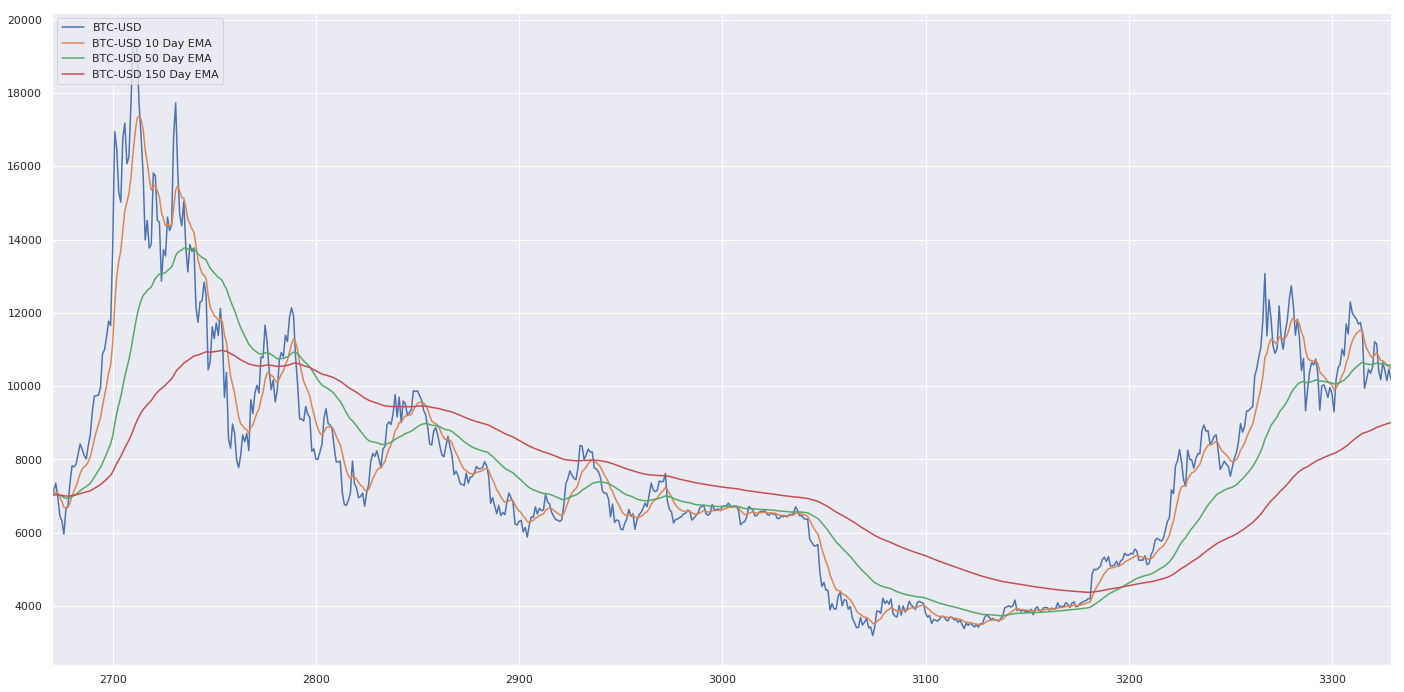

In [29]:
close_px = df_ols['Adj Close Test'] 
exp1 = close_px.ewm(span=10, adjust=False).mean()
exp2 = close_px.ewm(span=50, adjust=False).mean()
exp3 = close_px.ewm(span=150, adjust=False).mean()

# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(24, 12))
mpl.__version__

close_px.plot(label='BTC-USD')
exp1.plot(label='BTC-USD 10 Day EMA')
exp2.plot(label='BTC-USD 50 Day EMA')
exp3.plot(label='BTC-USD 150 Day EMA')
plt.legend(loc='upper left')
plt.show()

This method seems to have worked quite well for our purposes.

## Method #2 - Polynomial Regression
This method seems very promising for financial regression and I need to look more deeply into it in the future. In this example I was unable to get useful predictions with this method.

https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions

https://towardsdatascience.com/polynomial-regression-bbe8b9d97491

This time we'll define the entire process of transformation, training, evaluation and plotting as a function, so that we can easily test different parameter values.

In [0]:
from sklearn.preprocessing import PolynomialFeatures

def create_polynomial_regression_model(degree):
  "Creates a polynomial regression model for the given degree"
  
  poly_features = PolynomialFeatures(degree=degree)
  
  # transforms the existing features to higher degree features.
  X_train_poly = poly_features.fit_transform(X_train)
  
  # fit the transformed features to Linear Regression
  poly_model = LinearRegression()
  poly_model.fit(X_train_poly, y_train)
  
  # predicting on training data-set
  y_train_predicted = poly_model.predict(X_train_poly)
  
  # predicting on test data-set
  y_test_predict = poly_model.predict(poly_features.fit_transform(X_test))
 
  
  # evaluating the model on training dataset
  rmse_train = np.sqrt(mean_squared_error(y_train, y_train_predicted))
  r2_train = r2_score(y_train, y_train_predicted)
  
  print("The model performance for the training set")
  print("-------------------------------------------")
  print("RMSE of training set is {}".format(rmse_train))
  print("R2 score of training set is {}".format(r2_train))
  
  # Plot what it looks like for the training data
  df_ols = df.copy()
  df_ols.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
  df_ols = df_ols.iloc[window_size:ind_split] # Past 32 days we don't know yet
  df_ols['Adj Close Train'] = y_train_predicted[:-window_size]
  df_ols.plot(label='BTC-USD', figsize=(24,12), title='Adjusted Closing Price', grid=True)
  #plt.xlim(end - datetime.timedelta(days = window_size), end)
  
  print("\n")
  
  # evaluating the model on test dataset
  rmse_test = np.sqrt(mean_squared_error(y_test, y_test_predict))
  r2_test = r2_score(y_test, y_test_predict)
  
  print("The model performance for the test set")
  print("-------------------------------------------")
  print("RMSE of test set is {}".format(rmse_test))
  print("R2 score of test set is {}".format(r2_test))
  
  # Plot the test data
  df_ols = df.copy()
  df_ols.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
  df_ols = df_ols.iloc[ind_split+window_size:] # Past 32 days we don't know yet
  df_ols['Adj Close Test'] = y_test_predict
  df_ols.plot(label='BTC-USD', figsize=(24,12), title='Adjusted Closing Price', grid=True)
  

We'll start with a low degree and see what we get:

The model performance for the training set
-------------------------------------------
RMSE of training set is 11.02755990268792
R2 score of training set is 0.9998685669043461


The model performance for the test set
-------------------------------------------
RMSE of test set is 21455.19508196989
R2 score of test set is -46.79624363710471


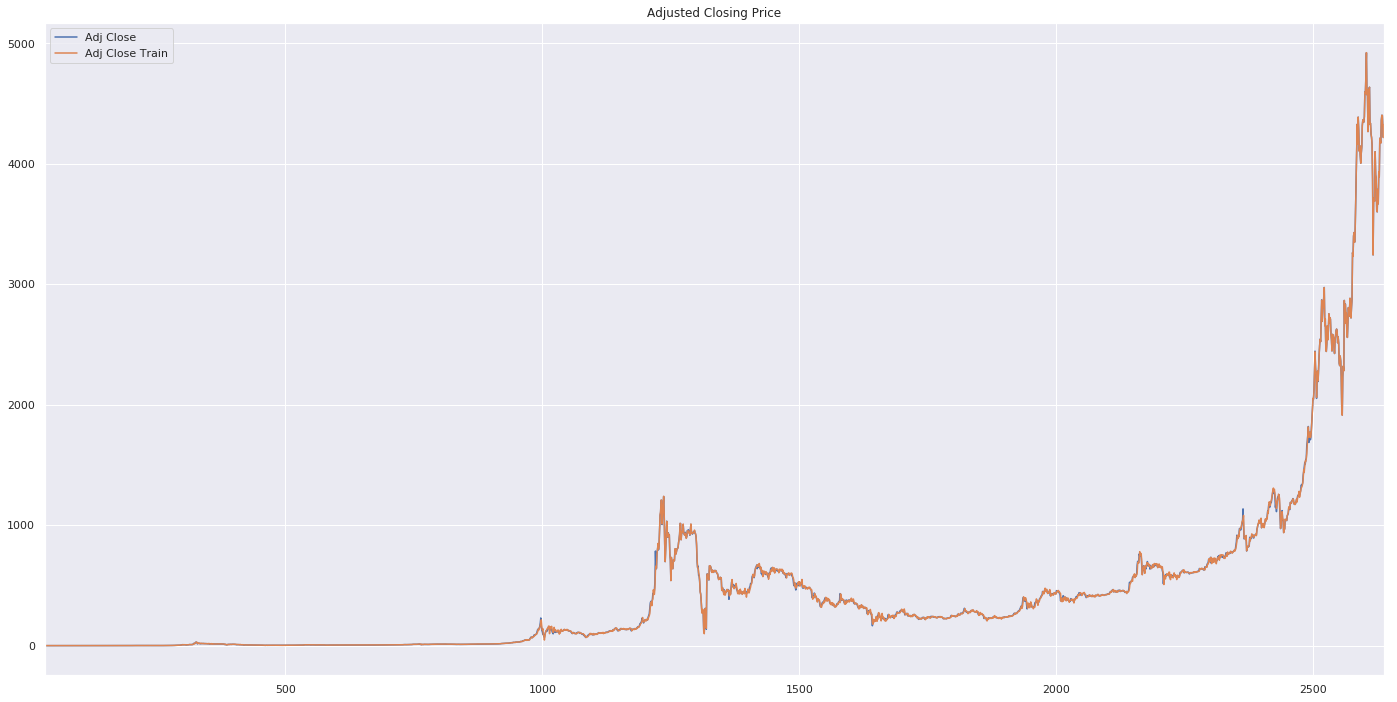

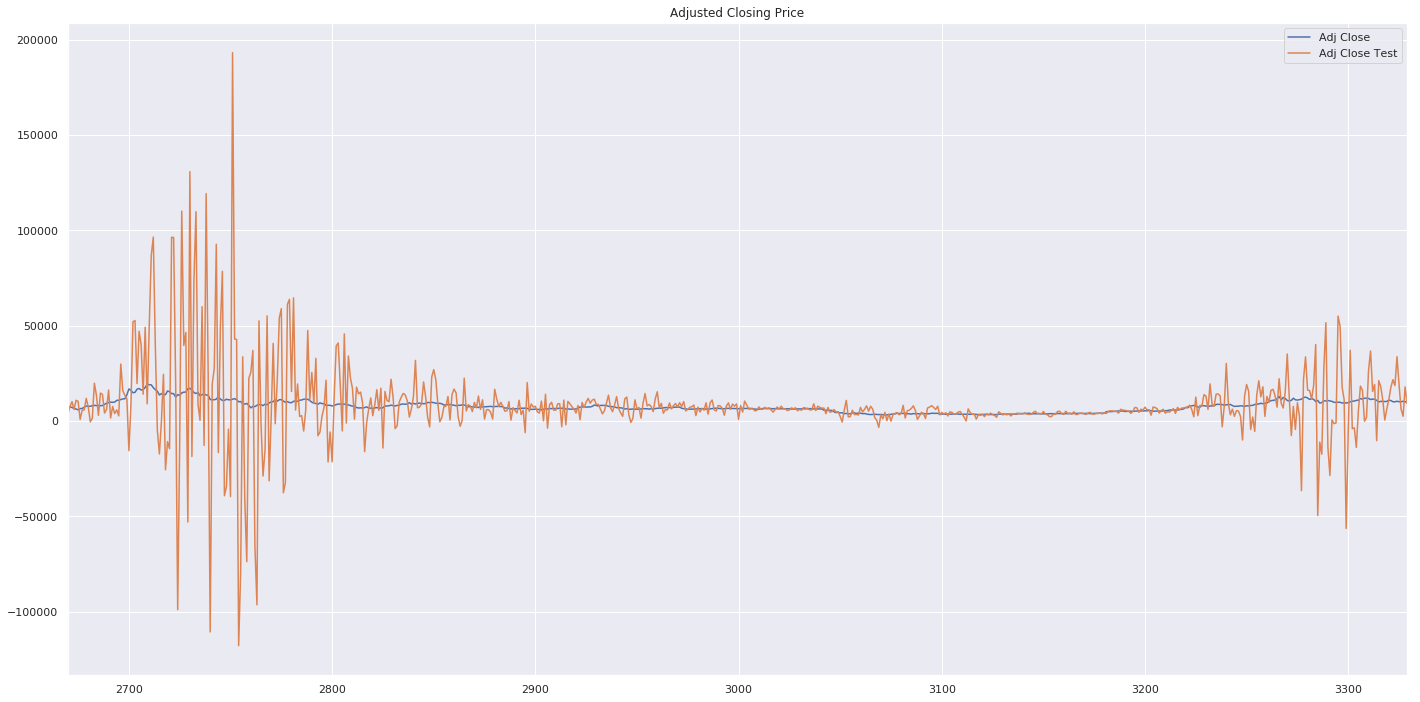

In [31]:
create_polynomial_regression_model(2)

...this is bizarre, and clearly incorrect. Our model seems to have performed reasonably on our training data, and plotted that correctly; on the testing data, however, it gives us a negative r-squared score and plots a graph which looks nothing like our test data did previously.

Let's see if increasing the degree helps at all:

The model performance for the training set
-------------------------------------------
RMSE of training set is 0.1504097236030638
R2 score of training set is 0.9999999755489388


The model performance for the test set
-------------------------------------------
RMSE of test set is 14458265109.062078
R2 score of test set is -21705070377405.434


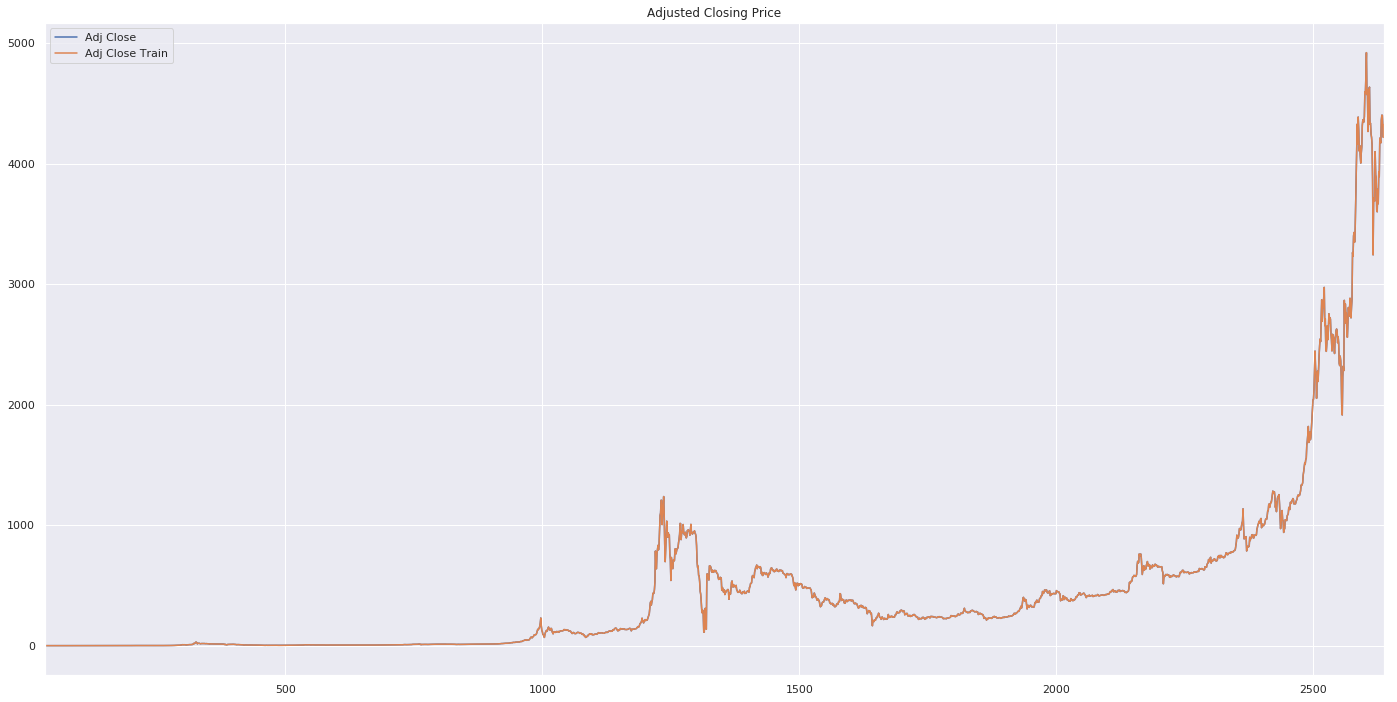

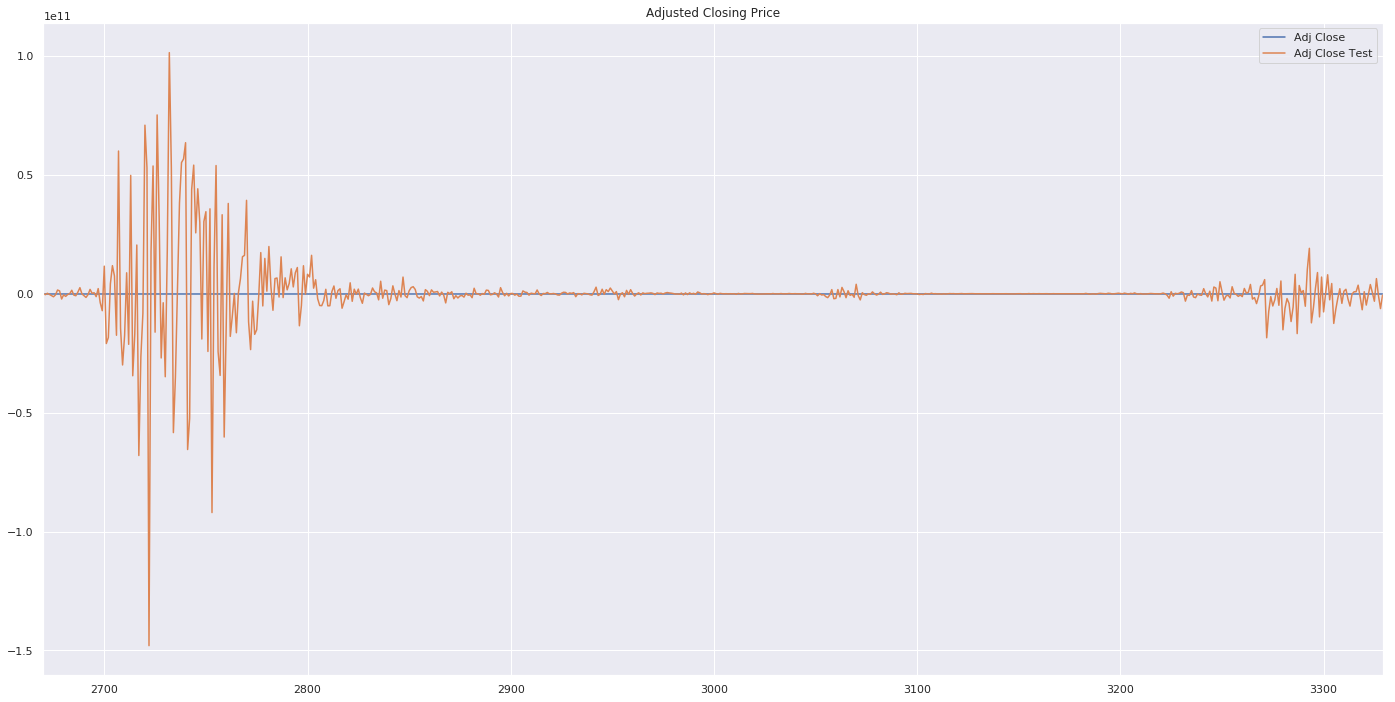

In [32]:
create_polynomial_regression_model(3)

Increasing the degree to four does not result in a better result. At higher than '4', it results in a crashed runtime.

We do see that the performance scores have gone to the moon. We also see a very flat feature landscape on the graph for the test data. My guess is that I have made an error in the way that the the polynomial feature transformation is implemented, and that it distorting the data itself rather than transforming its prediction of it.

Let's leave this mystery for now, and see how another algorithm does.

## Method #3 - Random Forest
This method seems to be good for many types of problem, both classification and regression. Maybe it can do well here.

It generates many decision trees on random features of the data, and intentionally allows them to have biased views of the data. It then sums the wisdom of the crowd, building a much clearer picture from their inter-subjective consensus.

In [0]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 10, random_state = 0, bootstrap = True, max_depth = 10, min_samples_split = 10)
rf.fit(X_train, y_train)

# Infer
y_pred_train_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

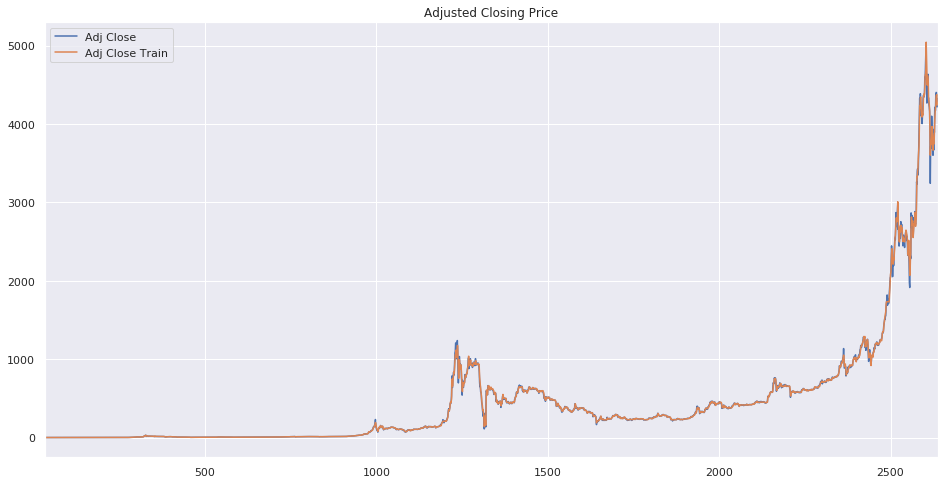

In [34]:
# Plot what it looks like for the training data
df_rf = df.copy()
df_rf.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_rf = df_rf.iloc[window_size:ind_split] # Past 32 days we don't know yet
df_rf['Adj Close Train'] = y_pred_train_rf[:-window_size]
df_rf.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

It seems to do well on the training dataset...

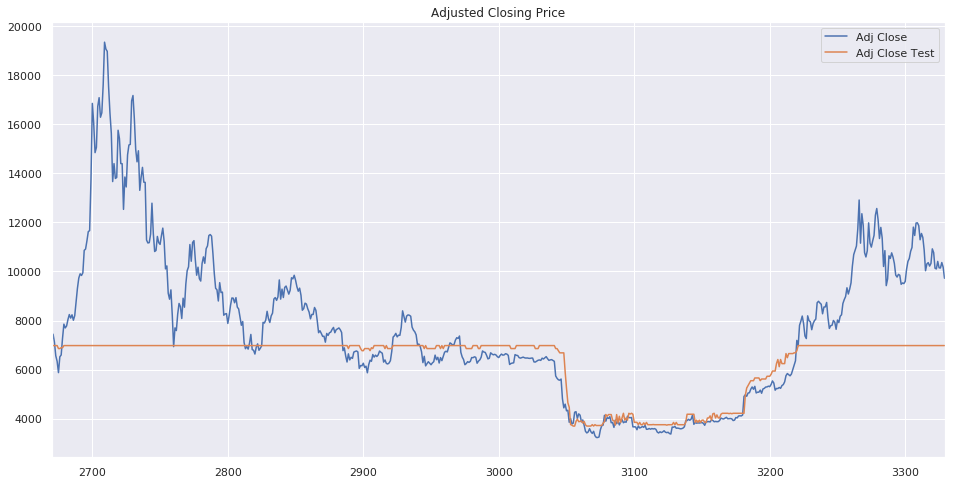

In [35]:
# Plot for the test set
df_rf = df.copy()
df_rf.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_rf = df_rf.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_rf['Adj Close Test'] = y_pred_rf
df_rf.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

...but it does horribly on the test set.

Maybe we can try adding more trees to the estimation?

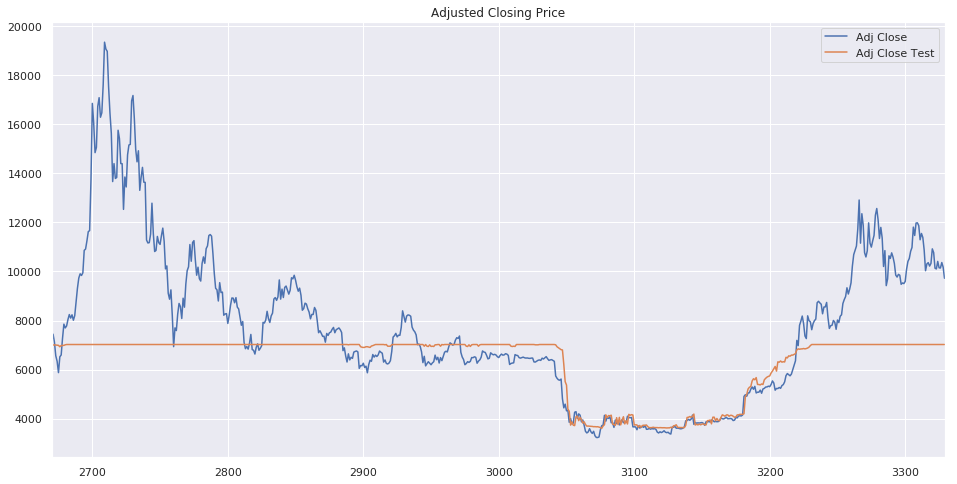

In [36]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 100, random_state = 0, bootstrap = True, max_depth = 10, min_samples_split = 10)
rf.fit(X_train, y_train)

# Infer
y_pred_train_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

# Plot for the test set
df_rf = df.copy()
df_rf.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_rf = df_rf.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_rf['Adj Close Test'] = y_pred_rf
df_rf.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)




The line is very slightly smoother but not obviously better in any way.

Let's try this one more time with a few random tweaks to our parameters to see if we can discern a relationship between input and output.

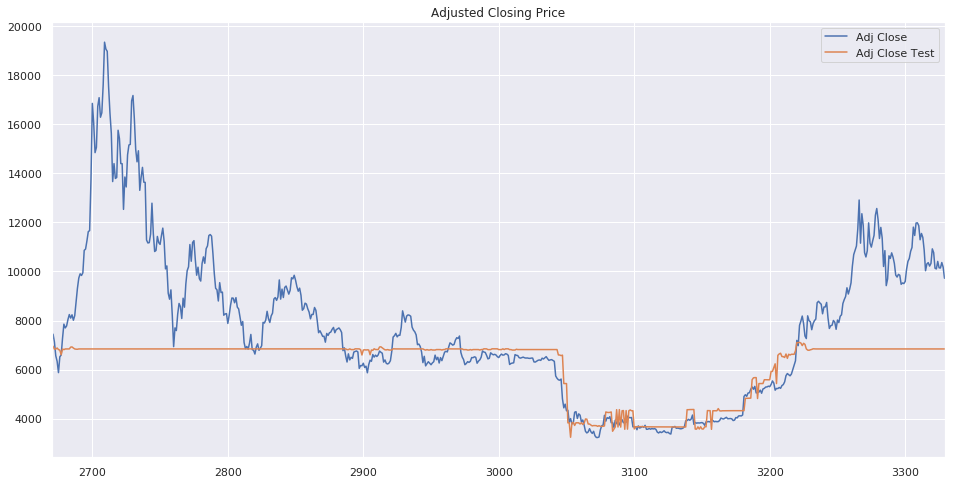

In [37]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 250, random_state = 65, bootstrap = False, max_depth = 10000, min_samples_split = 2)
rf.fit(X_train, y_train)

# Infer
y_pred_train_rf = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

# Plot for the test set
df_rf = df.copy()
df_rf.drop(['Open', 'High', 'Low', 'Close', 'Volume'], axis=1, inplace=True)
df_rf = df_rf.iloc[ind_split+window_size:] # Past 32 days we don't know yet
df_rf['Adj Close Test'] = y_pred_rf
df_rf.plot(label='BTC-USD', figsize=(16,8), title='Adjusted Closing Price', grid=True)

Just for fun, let's throw the moving averages on this:

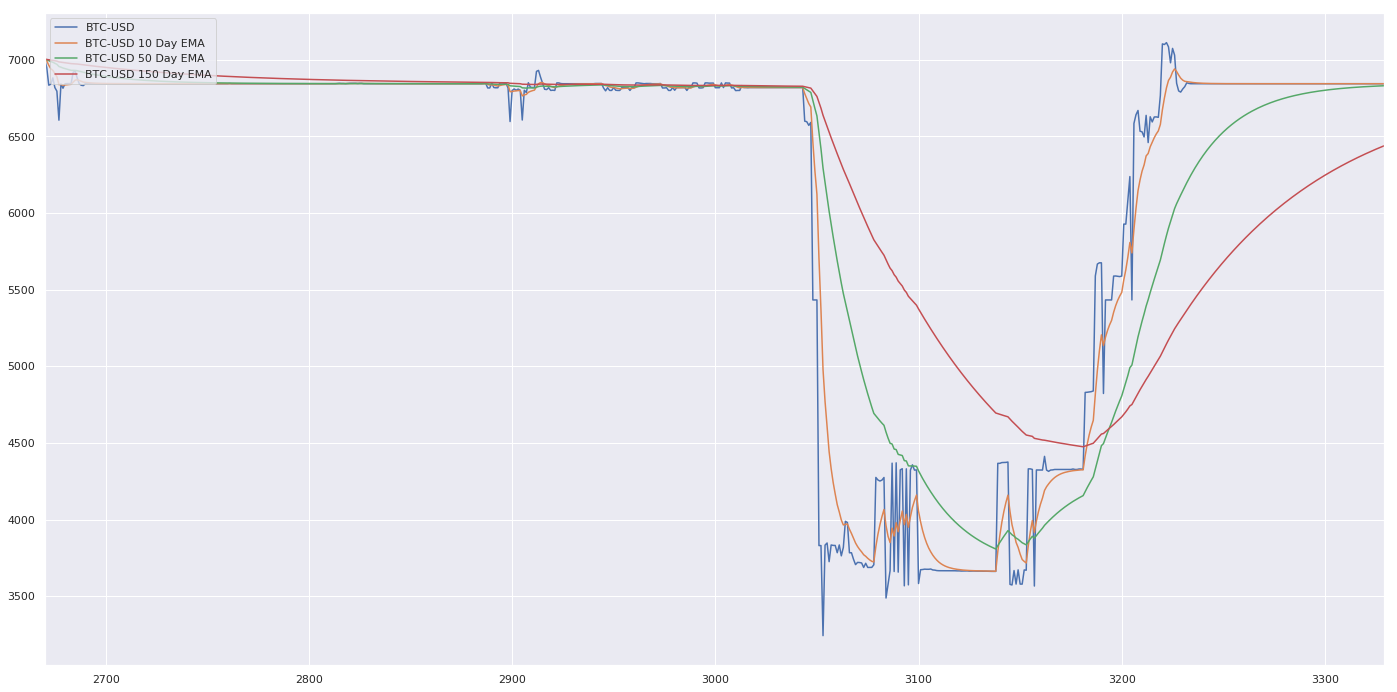

In [38]:
close_px = df_rf['Adj Close Test'] 
exp1 = close_px.ewm(span=10, adjust=False).mean()
exp2 = close_px.ewm(span=50, adjust=False).mean()
exp3 = close_px.ewm(span=150, adjust=False).mean()

# Adjusting the size of matplotlib
mpl.rc('figure', figsize=(24, 12))
mpl.__version__

close_px.plot(label='BTC-USD')
exp1.plot(label='BTC-USD 10 Day EMA')
exp2.plot(label='BTC-USD 50 Day EMA')
exp3.plot(label='BTC-USD 150 Day EMA')
plt.legend(loc='upper left')
plt.show()

#Conclusion

Out of the methods tried, the simple linear regression model seemed to give the best performance.

I'll need to return to this at some point and attempt a different approach to slicing and transforming the data to get the linear regression technique working properly.

Random forest seems like a good technique for other problems, but its utility for financial data appears to be limited.